In [1]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!mkdir images
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.8.0+cu126
Torchvision version: 0.23.0+cu126
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-lh2dl89k
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-lh2dl89k
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=b6117f3672d458e99c4c8654c454cb0911d964891a76f7bc2ac5c18a19ba9e3c
  Stored in directory: /tmp/pip-ephem-wheel-cache-30dlw360/wheels/29/82/ff/04e2be9805a1cb48bec0b85b5a6da6b63f647645750a0e42d4
Successfully built segment_anything
--2025-11-10 13:55:58--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com

[0, 296, 799, 231]


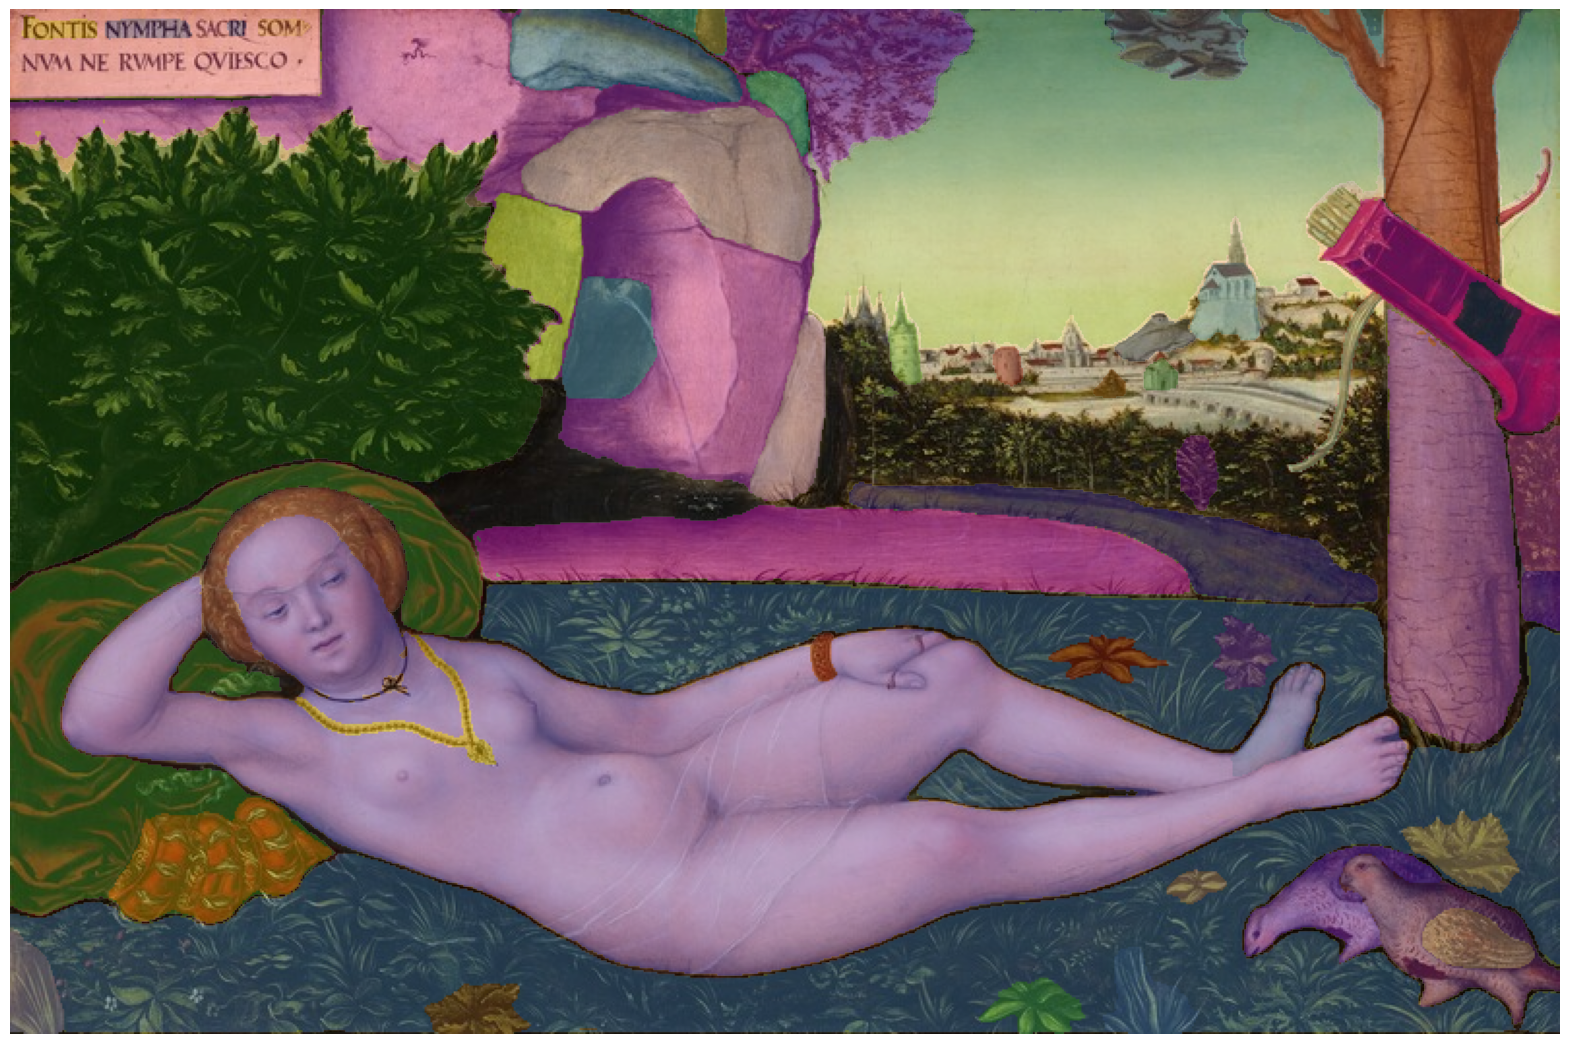

In [15]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
#from https://github.com/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

#cpu if run locally, cuda otherwise
device = "cuda"
model_type = "vit_h"
sam_checkpoint = "sam_vit_h_4b8939.pth"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)
image = cv2.imread("images/image4.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

masks = mask_generator.generate(image)
print(masks[0].get("bbox"))
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()



In [13]:
#!pip install pyefd


In [23]:
from skimage import io, color

image = cv2.imread("images/image4.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image2 = cv2.imread("images/image3.jpg")
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
masks = mask_generator.generate(image)
masks2 = mask_generator.generate(image2)



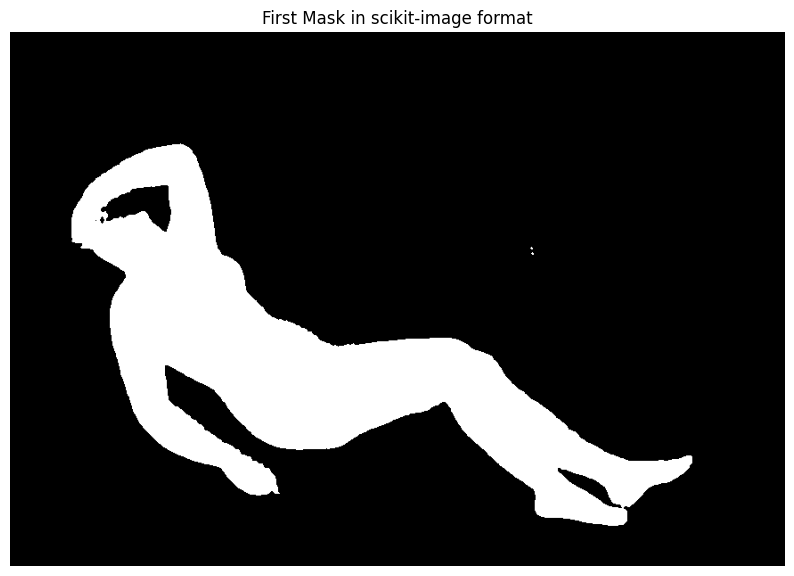

In [56]:
def mask_skimage(masks):
  skimage_masks = []
  for mask in masks:
      # The segmentation mask is a boolean numpy array
      segmentation = mask['segmentation']
      # Convert the boolean mask to an image (e.g., grayscale)
      # You can adjust this based on how you want to represent the mask in scikit-image
      skimage_mask = segmentation.astype(np.uint16)  # Convert to 0-255 grayscale image
      skimage_masks.append(skimage_mask)
  return skimage_masks

skimage_masks = mask_skimage(masks)
skimage_masks2 = mask_skimage(masks2)
# Now you have a list of masks in scikit-image format (numpy arrays)
# You can further process or save these masks as needed
# For example, to display the first mask:
plt.figure(figsize=(10, 10))
plt.imshow(skimage_masks2[0], cmap='gray')
plt.title("First Mask in scikit-image format")
plt.axis('off')
plt.show()

# Or save the first mask as an image file:

In [76]:
from pyefd import elliptic_fourier_descriptors
import cv2

# Function to find contours in a binary mask
def find_contours(mask):
    # Find contours in the binary mask
    # Use cv2.RETR_EXTERNAL to retrieve only the outer contours
    # Use cv2.CHAIN_APPROX_SIMPLE to compress horizontal, vertical, and diagonal segments
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

# Get contours for the selected masks
contours1 = []
contours2 = []
for mask in skimage_masks:
    l = find_contours(mask)
    if l:
        contours1.append(l)

for mask in skimage_masks2:
    l = find_contours(mask)
    if l:
        contours2.append(l)



# Check if contours were found
if contours1 and contours2:
    # Calculate elliptic Fourier descriptors for the first contour found in each mask
    # You might need to select the appropriate contour if multiple are found
    coeffs1 = []
    coeffs2 = []
    for i in range(len(contours1)):
        if len(contours1[i][0].squeeze()) >5:
          coeffs1.append(elliptic_fourier_descriptors(contours1[i][0].squeeze(), order=10, normalize=True))
    for i in range(len(contours2)):
        coeffs2.append(elliptic_fourier_descriptors(contours2[i][0].squeeze(), order=10, normalize=True))
else:
    print("Could not find contours in one or both masks.")


Principal Components:
 [[-2.69762557e-01 -7.71257847e-02]
 [ 3.13680546e-01  9.15886736e-02]
 [-2.06898627e-01 -2.76182274e-02]
 [ 1.82885308e-01 -2.45445317e-02]
 [-9.38244759e-02  5.08541956e-01]
 [ 1.80995708e-01 -2.90568061e-02]
 [ 9.38892132e-02 -1.02840879e-02]
 [ 1.88898552e-01 -2.50161848e-02]
 [ 5.71753584e-01 -2.54908680e-01]
 [-1.92301878e-01 -3.77153659e-02]
 [ 2.20329908e-01 -6.45473525e-02]
 [ 1.64144854e-01 -1.86242417e-01]
 [ 2.46282397e-01 -5.26917318e-02]
 [ 1.98828877e-01 -1.75118727e-01]
 [ 1.30356855e-01  2.07550019e-02]
 [ 4.27742017e-02 -9.32405079e-03]
 [-1.49248143e-01 -6.82860376e-01]
 [ 1.66597049e-01  1.38883500e-02]
 [ 2.77482406e-01  9.03088955e-03]
 [-3.65044298e-02 -1.16781301e-01]
 [ 1.20418121e-01  1.07532158e-01]
 [ 1.17218273e-01  1.29704182e-01]
 [ 4.37183051e-01 -4.80798363e-02]
 [-1.09140636e-01  2.53618525e-04]
 [ 1.76297721e-01 -1.43394722e-01]
 [ 3.92077766e-01  7.17609655e-01]
 [ 7.28792622e-03 -1.61815296e-02]
 [-6.15978479e-02  2.09243814e-0

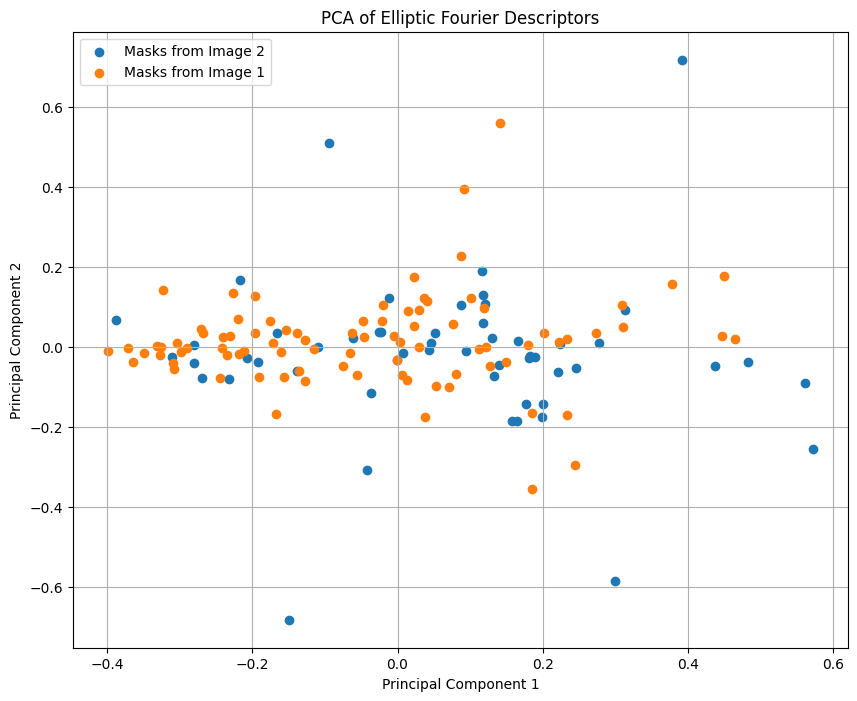

In [78]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Flatten and reshape all coefficients from both lists
all_coeffs_list = []
for coeffs in coeffs1 + coeffs2:
    all_coeffs_list.append(np.array(coeffs).flatten())

# Find the maximum length of the flattened coefficient arrays
max_len = max(len(coeffs) for coeffs in all_coeffs_list)

# Pad all flattened coefficient arrays to the maximum length
all_coeffs_padded = []
for coeffs in all_coeffs_list:
    padding_size = max_len - len(coeffs)
    padded_coeffs = np.pad(coeffs, (0, padding_size), 'constant')
    all_coeffs_padded.append(padded_coeffs)

# Stack the padded coefficient arrays into a single numpy array
all_coeffs_stacked = np.vstack(all_coeffs_padded)

# Perform PCA
# Choose the number of components based on the number of samples and features
n_components = min(all_coeffs_stacked.shape[0], all_coeffs_stacked.shape[1])
if n_components > 1:
    pca = PCA(n_components=2) # Use 2 components for a 2D scatter plot if possible
    principal_components = pca.fit_transform(all_coeffs_stacked)

    print("Principal Components:\n", principal_components)
    print("Explained variance ratio:", pca.explained_variance_ratio_)

    # Plot the PCA results
    plt.figure(figsize=(10, 8))
    # Distinguish between coefficients from coeffs1 and coeffs2 in the plot
    num_coeffs1 = len(coeffs1)
    plt.scatter(principal_components[:num_coeffs1, 0], principal_components[:num_coeffs1, 1], label='Masks from Image 2')
    plt.scatter(principal_components[num_coeffs1:, 0], principal_components[num_coeffs1:, 1], label='Masks from Image 1')

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA of Elliptic Fourier Descriptors')
    plt.legend()
    plt.grid(True)
    plt.show()
elif n_components == 1:
    pca = PCA(n_components=1)
    principal_components = pca.fit_transform(all_coeffs_stacked)
    print("Principal Components:\n", principal_components)
    print("Explained variance ratio:", pca.explained_variance_ratio_)

    plt.figure(figsize=(10, 4))
    num_coeffs1 = len(coeffs1)
    plt.scatter(principal_components[:num_coeffs1, 0], np.zeros(num_coeffs1), label='Masks from Image 2')
    plt.scatter(principal_components[num_coeffs1:, 0], np.zeros(len(coeffs2)), label='Masks from Image 1')
    plt.xlabel('Principal Component 1')
    plt.title('PCA of Elliptic Fourier Descriptors (1 Component)')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Not enough data points or features to perform PCA.")